# Count output read classes

# NanoPrePro

In [1]:
from types import SimpleNamespace
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import pandas as pd
import json, os

# paths
path_workdir = Path("/home/b05b01002/HDD/project_nanoprep_re")
path_output = Path("./output")
os.makedirs(path_output, exist_ok=True)

# NanoPrePro report file name template
path_report = lambda wildcards: \
    path_workdir / f"outputs/NanoPreP/mprof_nanoprep/{wildcards.beta_or_backend}/{wildcards.name}_{wildcards.accuracy}/report.html"

# wildcards
names = [
    "egr-109-bio1",
    "egr-109-bio2",
    "lch-109-bio1",
    "lch-109-bio2",
    "ptr-109-bio1",
    "ptr-109-bio2",
    "ptr-111-bio1",
    "ont-10x-human",
    "ont-visium-mouse",
    "mouse-retina-subset1",
    "mouse-retina-subset2"
]
accuracies = [
    "sup",
    "hac",
    "fast",
    "pre-called"
]
betas = [f"beta{i}" for i in ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0", "1.5", "2.0"]]
backends = ["phmm", "edlib"]
softwares = ["pychopper", "nanoprep"]

In [2]:
read_types = []
for beta in betas:
    for name in names:
        if name in ["mouse-retina-subset1", "mouse-retina-subset2"]:
            accuracies_tmp = accuracies[3:]
        else:
            accuracies_tmp = accuracies[:3]
        for accuracy in accuracies_tmp:
            wildcards = SimpleNamespace(beta_or_backend=beta, name=name, accuracy=accuracy)
            fpath = path_report(wildcards)
            if not fpath.is_file():
                print(f"missing {fpath}")
                continue
            with open(fpath) as handle_in:
                data = json.load(handle_in)
            read_types.append({
                "beta_or_backend": beta,
                "name": name,
                "accuracy": accuracy,
                "full-length": data["full-length/passed"],
                "truncated": data["truncated/passed"],
                "fusion": data["fusion/passed"]
            })

In [3]:
data = pd.DataFrame(read_types)
data["full-length percentage"] = data["full-length"] / (data["full-length"] + data["truncated"] + data["fusion"])
data["truncated percentage"] = data["truncated"] / (data["full-length"] + data["truncated"] + data["fusion"])
data["fusion percentage"] = data["fusion"] / (data["full-length"] + data["truncated"] + data["fusion"])
data.to_csv("read-types_nanoprepro.csv", index=False)

# Pychopper

In [4]:
# paths
path_workdir = Path("/home/b05b01002/HDD/project_nanoprep_re")
path_output = Path("./output")
os.makedirs(path_output, exist_ok=True)

# NanoPrePro report file name template
path_reads = lambda wildcards: \
    path_workdir / f"outputs/Pychopper/mprof_pychopper/{wildcards.backend}/{wildcards.name}_{wildcards.accuracy}/"

# wildcards
names = [
    "egr-109-bio1",
    "egr-109-bio2",
    "lch-109-bio1",
    "lch-109-bio2",
    "ptr-109-bio1",
    "ptr-109-bio2",
    "ptr-111-bio1",
    "ont-10x-human",
    "ont-visium-mouse",
    "mouse-retina-subset1",
    "mouse-retina-subset2"
]
accuracies = [
    "sup",
    "hac",
    "fast",
    "pre-called"
]
backends = ["phmm", "edlib"]

In [5]:
read_types_py = []
for backend in backends:
    for name in names:
        if name in ["mouse-retina-subset1", "mouse-retina-subset2"]:
            accuracies_tmp = accuracies[3:]
        else:
            accuracies_tmp = accuracies[:3]
        for accuracy in accuracies_tmp:
            wildcards = SimpleNamespace(backend=backend, name=name, accuracy=accuracy)
            dir_path = path_reads(wildcards)
            if not dir_path.is_dir():
                print(f"no dir: {dir_path}")
                continue
            n_fl = subprocess.run(["wc", "-l", str(dir_path / "full-length.fq")], capture_output=True, text=True, check=True).stdout.split(" ")[0]
            n_tr = subprocess.run(["wc", "-l", str(dir_path / "truncated.fq")], capture_output=True, text=True, check=True).stdout.split(" ")[0]
            n_fu = subprocess.run(["wc", "-l", str(dir_path / "chimeric.fq")], capture_output=True, text=True, check=True).stdout.split(" ")[0]
            n_fl = int(n_fl) // 4
            n_tr = int(n_tr) // 4
            n_fu = int(n_fu) // 4
            read_types_py.append({
                "beta_or_backend": backend,
                "name": name,
                "accuracy": accuracy,
                "full-length": n_fl,
                "truncated": n_tr,
                "fusion": n_fu,
                "full-length percentage": n_fl / (n_fl + n_tr + n_fu),
                "truncated percentage": n_tr / (n_fl + n_tr + n_fu),
                "fusion percentage": n_fu / (n_fl + n_tr + n_fu)
            })

no dir: /home/b05b01002/HDD/project_nanoprep_re/outputs/Pychopper/mprof_pychopper/phmm/mouse-retina-subset1_pre-called
no dir: /home/b05b01002/HDD/project_nanoprep_re/outputs/Pychopper/mprof_pychopper/phmm/mouse-retina-subset2_pre-called
no dir: /home/b05b01002/HDD/project_nanoprep_re/outputs/Pychopper/mprof_pychopper/edlib/mouse-retina-subset1_pre-called
no dir: /home/b05b01002/HDD/project_nanoprep_re/outputs/Pychopper/mprof_pychopper/edlib/mouse-retina-subset2_pre-called


In [6]:
data = pd.DataFrame(read_types_py)
data.to_csv("read-types_pychopper.csv", index=False)

# Combined

In [4]:
data_np = pd.read_csv("read-types_nanoprepro.csv")
data_py = pd.read_csv("read-types_pychopper.csv")
data = pd.concat([data_py, data_np])
data

,beta_or_backend,name,accuracy,full-length,truncated,fusion,full-length percentage,truncated percentage,fusion percentage
0,phmm,egr-109-bio1,sup,77984,10535,1240,0.868815,0.117370,0.013815
1,phmm,egr-109-bio1,hac,76339,9358,1216,0.878338,0.107671,0.013991
2,phmm,egr-109-bio1,fast,67783,11729,1045,0.841429,0.145599,0.012972
3,phmm,egr-109-bio2,sup,80466,9914,1359,0.877119,0.108067,0.014814
4,phmm,egr-109-bio2,hac,78726,9127,1319,0.882856,0.102353,0.014792
...,...,...,...,...,...,...,...,...,...
343,beta2.0,ont-visium-mouse,sup,223230,14946,6048,0.914038,0.061198,0.024764
344,beta2.0,ont-visium-mouse,hac,226864,12724,6277,0.922718,0.051752,0.025530
345,beta2.0,ont-visium-mouse,fast,214694,17461,7779,0.894804,0.072774,0.032421
346,beta2.0,mouse-retina-subset1,pre-called,91902,7013,1013,0.919682,0.070181,0.010137


In [5]:
data["kit"] = data["name"].map({
    "egr-109-bio1": "PCS109",
    "egr-109-bio2": "PCS109",
    "lch-109-bio1": "PCS109",
    "lch-109-bio2": "PCS109",
    "ptr-109-bio1": "PCS109",
    "ptr-109-bio2": "PCS109",
    "ptr-111-bio1": "PCS111",
    "ont-10x-human": "LSK114",
    "ont-visium-mouse": "LSK114",
    "mouse-retina-subset1": "PCS114",
    "mouse-retina-subset2": "PCS114"
})
is_pychopper = data["beta_or_backend"].isin(["phmm", "edlib"])
data["software"] = "nanoprepro"
data.loc[is_pychopper, "software"] = "pychopper"
data.loc[data["accuracy"] == "pre-called", "accuracy"] = "sup"

In [6]:
plot_data = pd.melt(
    data[data["software"] == "pychopper"],
    id_vars=["beta_or_backend", "name", "accuracy"],
    value_vars=["full-length percentage", "truncated percentage", "fusion percentage"],
    var_name="read-type",
    value_name="percentage"
)

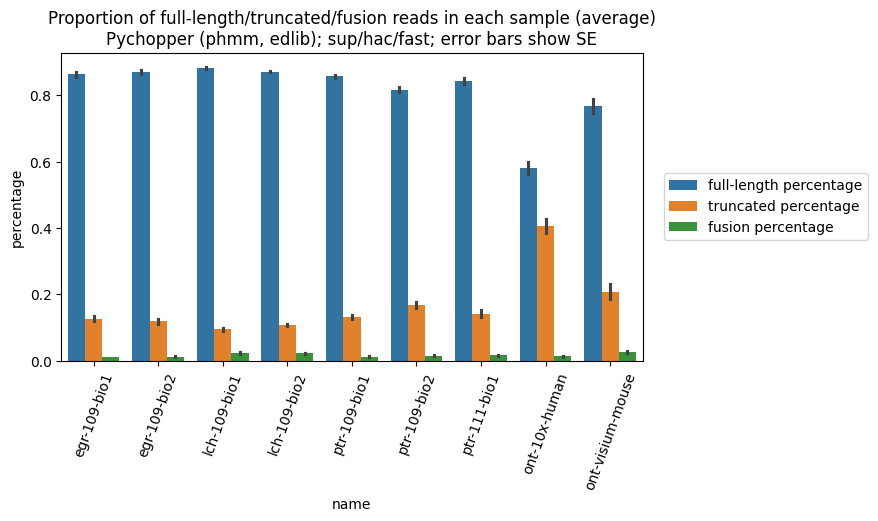

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 4))
sns.barplot(
    plot_data,
    x="name",
    y="percentage",
    hue="read-type",
    errorbar="se",
    ax=ax
)
# sns.stripplot(
#     plot_data,
#     x="name",
#     y="percentage",
#     hue="beta_or_backend",
#     palette="viridis_r",
#     ax=ax
# )
# sns.stripplot(data[data["software"] == "nanoprepro"], x="name", y="full-length percentage", hue="accuracy", palette="Set2", s=3, ax=ax)
ax.tick_params(axis="x", rotation=70)
ax.legend(loc="center right", bbox_to_anchor=(1.4, 0.5))
ax.set_title("Proportion of full-length/truncated/fusion reads in each sample (average)\nPychopper (phmm, edlib); sup/hac/fast; error bars show SE")
fig.savefig("output/pychopper-read-type-proportion-barplot.svg")

In [8]:
plot_data = pd.melt(
    data[data["software"] == "nanoprepro"],
    id_vars=["beta_or_backend", "name", "accuracy"],
    value_vars=["full-length percentage", "truncated percentage", "fusion percentage"],
    var_name="read-type",
    value_name="percentage"
)

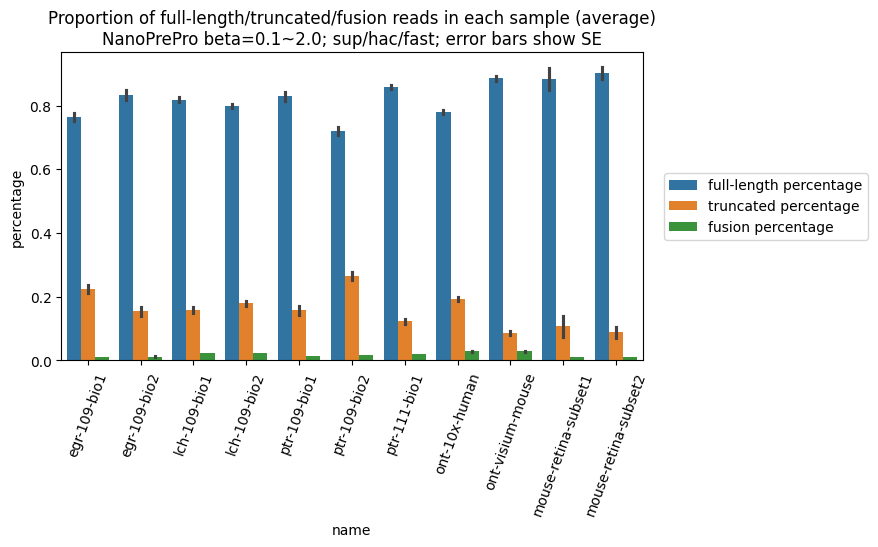

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 4))
sns.barplot(
    plot_data,
    x="name",
    y="percentage",
    hue="read-type",
    errorbar="se",
    ax=ax
)
# sns.stripplot(
#     plot_data,
#     x="name",
#     y="percentage",
#     hue="beta_or_backend",
#     palette="viridis_r",
#     ax=ax
# )
# sns.stripplot(data[data["software"] == "nanoprepro"], x="name", y="full-length percentage", hue="accuracy", palette="Set2", s=3, ax=ax)
ax.tick_params(axis="x", rotation=70)
ax.legend(loc="center right", bbox_to_anchor=(1.4, 0.5))
ax.set_title("Proportion of full-length/truncated/fusion reads in each sample (average)\nNanoPrePro beta=0.1~2.0; sup/hac/fast; error bars show SE")
fig.savefig("output/nanoprep-read-type-proportion-barplot.svg")

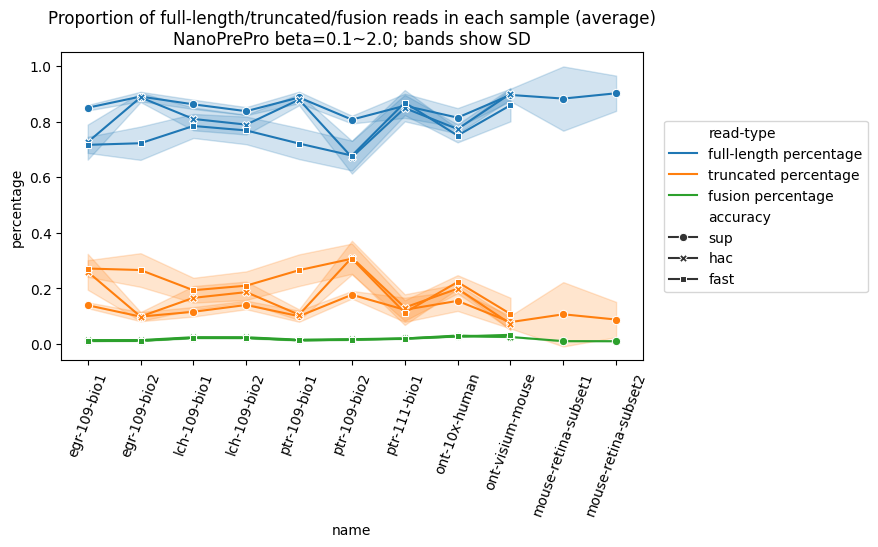

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 4))
sns.lineplot(
    plot_data,
    x="name",
    y="percentage",
    hue="read-type",
    style="accuracy",
    estimator=lambda x: np.mean(x),
    errorbar="sd",
    markers=True,
    dashes=False,
    ax=ax
)
# sns.stripplot(
#     plot_data,
#     x="name",
#     y="percentage",
#     hue="read-type",
#     s=3,
#     ax=ax
# )
# sns.stripplot(data[data["software"] == "nanoprepro"], x="name", y="full-length percentage", hue="accuracy", palette="Set2", s=3, ax=ax)
ax.tick_params(axis="x", rotation=70)
ax.legend(loc="center right", bbox_to_anchor=(1.4, 0.5))
ax.set_title("Proportion of full-length/truncated/fusion reads in each sample (average)\nNanoPrePro beta=0.1~2.0; bands show SD")
fig.savefig("output/nanoprep-read-type-proportion-lineplot.svg")

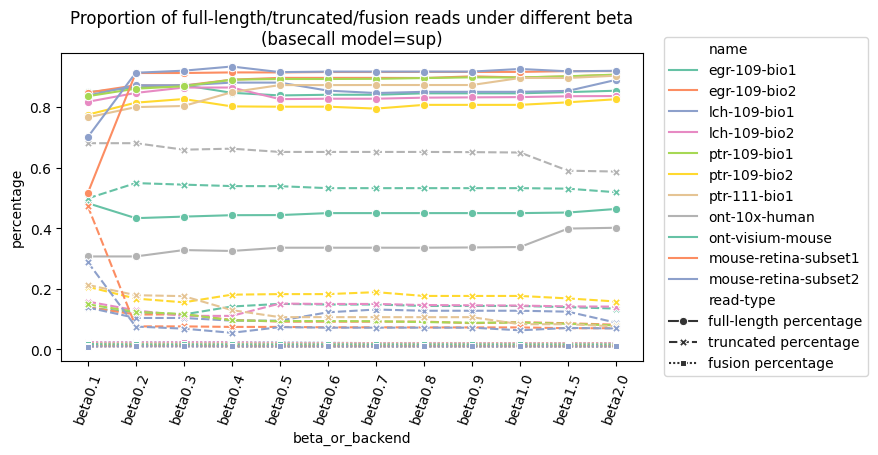

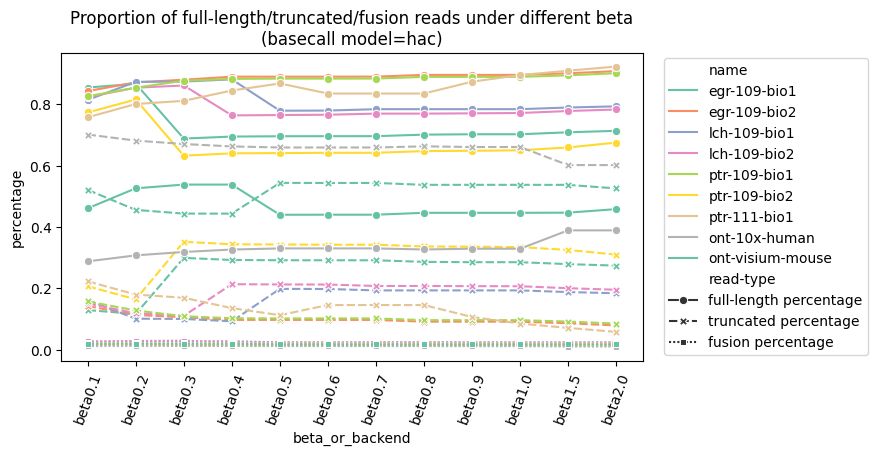

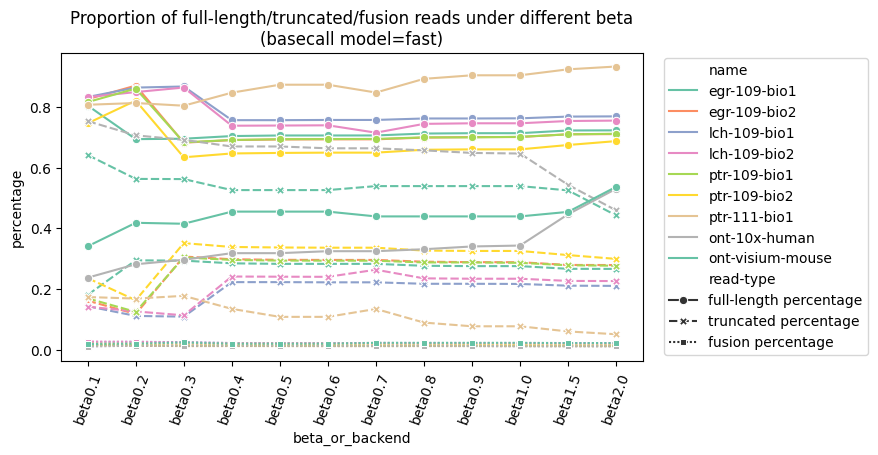

In [29]:
for accuracy in ["sup", "hac", "fast"]:
    fig, ax = plt.subplots(1, 1, figsize=(7.5, 4))
    sns.lineplot(
        plot_data[(plot_data["accuracy"] == accuracy)],
        x="beta_or_backend",
        y="percentage",
        hue="name",
        style="read-type",
        markers=True,
        dashes=True,
        palette="Set2",
        ax=ax
    )
    # sns.stripplot(
    #     plot_data,
    #     x="name",
    #     y="percentage",
    #     hue="read-type",
    #     s=3,
    #     ax=ax
    # )
    # sns.stripplot(data[data["software"] == "nanoprepro"], x="name", y="full-length percentage", hue="accuracy", palette="Set2", s=3, ax=ax)
    ax.tick_params(axis="x", rotation=70)
    ax.legend(loc="center right", bbox_to_anchor=(1.4, 0.5))
    ax.set_title(f"Proportion of full-length/truncated/fusion reads under different beta\n(basecall model={accuracy})")
    # fig.savefig(f"output/nanoprep-read-type-proportion-by-beta-{accuracy}.svg")